In [14]:
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import matplotlib.pyplot as plt
import imageio

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


## Creacion del modelo


In [16]:
# Modelo de Red Neuronal en PyTorch
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

## Clase DQNAgent con historial de pérdidas


In [17]:
class DQNAgent:
    def __init__(
        self,
        state_dim,
        action_dim,
        replay_size=1000,
        batch_size=256,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.99,
        epsilon_min=0.01,
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.replay_buffer = deque(maxlen=replay_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.loss_history = []

        # Redes Q y Target
        self.q_network = DQN(state_dim, action_dim).to(device)
        self.target_network = DQN(state_dim, action_dim).to(device)
        self.update_target_network()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.0005)
        self.criterion = nn.MSELoss()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        state = torch.FloatTensor(state).to(device).unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_network(state)
        return torch.argmax(q_values).item()

    def store_experience(self, state, action, reward, next_state, terminated):
        self.replay_buffer.append((state, action, reward, next_state, terminated))

    def train(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, terminateds = zip(*batch)

        states = torch.FloatTensor(states).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        actions = torch.LongTensor(actions).to(device)
        terminateds = torch.FloatTensor(terminateds).to(device)

        q_values = self.q_network(states)
        next_q_values = self.target_network(next_states)

        q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
        max_next_q_values = next_q_values.max(1)[0]
        targets = rewards + self.gamma * max_next_q_values * (1 - terminateds)

        loss = self.criterion(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.loss_history.append(loss.item())

In [18]:
def plot_metrics(scores, loss_history):
    plt.figure(figsize=(10, 6))
    plt.plot(scores, label="Puntaje por episodio")
    plt.xlabel("Episodio")
    plt.ylabel("Puntaje")
    plt.title("Evolución del Puntaje")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, label="Pérdida por batch")
    plt.xlabel("Batch")
    plt.ylabel("Pérdida (Loss)")
    plt.title("Evolución de la Pérdida")
    plt.legend()
    plt.grid()
    plt.show()

## Entrenamiento del DQN con métricas y video


In [ ]:
def train_dqn(
    env_name="Acrobot-v1", episodes=10, target_update=5, gif_filename="dqn_training.gif"
):
    env = gym.make(env_name, render_mode="human")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = DQNAgent(state_dim, action_dim)
    scores = []
    frames = []

    for episode in range(episodes):
        state = env.reset()[0]
        episode_score = 0
        while True:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            agent.store_experience(state, action, reward, next_state, terminated)
            agent.train()
            state = next_state
            episode_score += reward

            frame = env.render()[0]
            frames.append(frame)  # Captura frame para el GIF

            if terminated or truncated:
                break

        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)
        scores.append(episode_score)

        if episode % target_update == 0:
            agent.update_target_network()

        print(
            f"Episode {episode}, Score: {episode_score}, Epsilon: {agent.epsilon:.2f}"
        )

    env.close()

    # Guardar el GIF
    imageio.mimsave(gif_filename, frames, duration=0.05)
    print(f"GIF guardado como: {gif_filename}")

    # Graficar métricas
    plot_metrics(scores, agent.loss_history)

## Entrenar y graficar resultados


Episode 0, Score: -500.0, Epsilon: 0.99
Episode 1, Score: -500.0, Epsilon: 0.98
Episode 2, Score: -500.0, Epsilon: 0.97
Episode 3, Score: -500.0, Epsilon: 0.96
Episode 4, Score: -500.0, Epsilon: 0.95
Episode 5, Score: -500.0, Epsilon: 0.94
Episode 6, Score: -500.0, Epsilon: 0.93
Episode 7, Score: -500.0, Epsilon: 0.92
Episode 8, Score: -500.0, Epsilon: 0.91
Episode 9, Score: -500.0, Epsilon: 0.90
Episode 10, Score: -500.0, Epsilon: 0.90
Episode 11, Score: -500.0, Epsilon: 0.89
Episode 12, Score: -500.0, Epsilon: 0.88
Episode 13, Score: -500.0, Epsilon: 0.87
Episode 14, Score: -500.0, Epsilon: 0.86
Episode 15, Score: -500.0, Epsilon: 0.85
Episode 16, Score: -500.0, Epsilon: 0.84
Episode 17, Score: -500.0, Epsilon: 0.83
Episode 18, Score: -494.0, Epsilon: 0.83
Episode 19, Score: -500.0, Epsilon: 0.82
Episode 20, Score: -500.0, Epsilon: 0.81
Episode 21, Score: -500.0, Epsilon: 0.80
Episode 22, Score: -485.0, Epsilon: 0.79
Episode 23, Score: -500.0, Epsilon: 0.79
Episode 24, Score: -353.0,

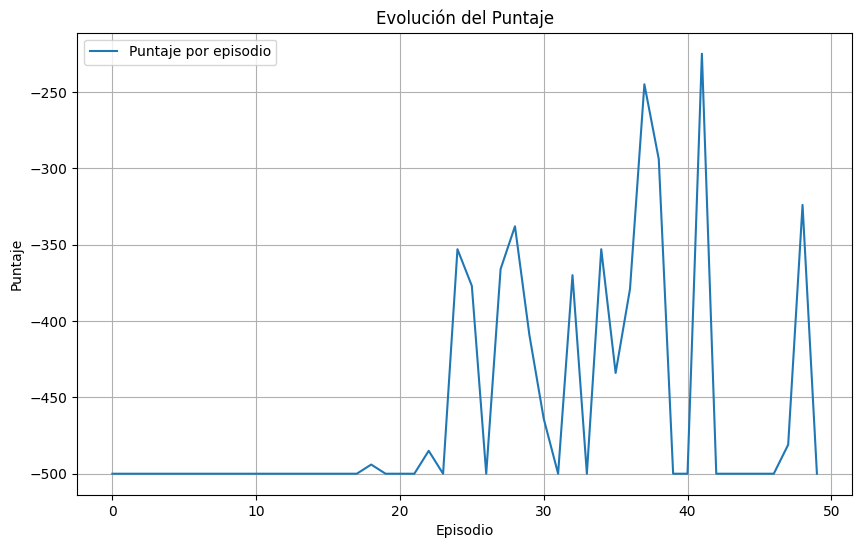

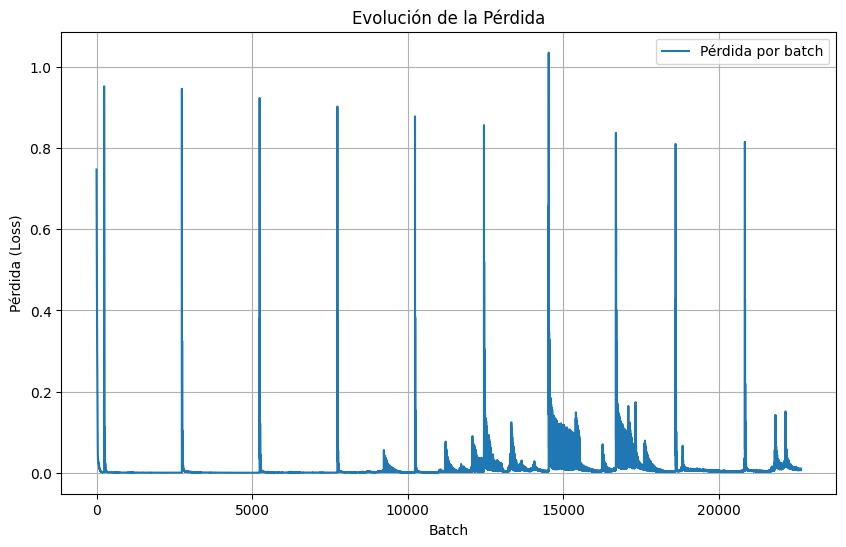

In [20]:
train_dqn(episodes=20)